In [99]:
import torch
from torch.autograd import grad
from torch.optim.lr_scheduler import ReduceLROnPlateau
import sys
import datetime
sys.path.append('..')
from src import train, utils
from src import calculus as calc
import src.data.cube_domain as cb
import src.models.mlp_model as mm

In [100]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TRAIN_TEMP_SAVE_PATH = './most_eff_model.pt'
NU = 1 / 100
RE = 1 / NU
T_MAX = 1
L_BOUNDS = [-0.5, -0.5]
U_BOUNDS = [0.5, 0.5]
A = 0.3  # used during training to select A percentage of points with smallest detection metric

In [101]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [102]:
class SplitDomain(cb.CubeDomain):
    def __init__(self, domain_ctx: cb.CubeContext):
        super(SplitDomain, self).__init__(domain_ctx)
        self.metric_computed = False

    def split_pts(self, det_metric: torch.Tensor):
        _, worst = torch.topk(det_metric, int(A * self.ctx.N_int), largest=False)
        self.bad_pts_mask = torch.zeros(det_metric.shape[0], dtype=torch.bool, device=device)
        self.bad_pts_mask[worst] = True

    def compute_detection_metric(self, u, input, dim):
        det_metric = 0

        for i in range(dim):
            abs_nabla_i = torch.abs(grad(u[:, i], input, torch.ones_like(u[:, i]), create_graph=True)[0])
            det_metric_i = torch.sum(abs_nabla_i, dim=1)
            det_metric += det_metric_i

        self.metric_computed = True

        return det_metric

In [103]:
# NOTE: input is assumed to have requires_grad=True
def pde_residuum(output: torch.Tensor, input: torch.Tensor) -> torch.Tensor:
    psi, p = output[:, :-1], output[:, -1:]
    psi_grad = grad(psi, input, torch.ones_like(psi), create_graph=True)[0]
    u = torch.cat([psi_grad[:, 1:2], -psi_grad[:, 0:1]], dim=1)
    lhs = calc.material_derivative(input, u, device, time_dependant=False)
    rhs = - calc.nabla(input, p, True) + NU * calc.laplacian(input, u, device, time_dependant=False)
    return lhs - rhs


def continuity_residuum(output: torch.Tensor, input: torch.Tensor) -> torch.Tensor:
    u, v = output[:, 0:1], output[:, 1:2]
    u_x = grad(u, input, torch.ones_like(u), create_graph=True)[0][:, 0:1]
    v_y = grad(v, input, torch.ones_like(v), create_graph=True)[0][:, 1:2]
    return u_x + v_y


In [104]:
include_ri = True

def SDF_weights(x):
    return 1.0 - 2.0 * torch.abs(x[:, 0:1])

def loss_fn(model: torch.nn.Module, domain: SplitDomain) -> torch.Tensor:
    # pde loss
    if include_ri:
        if not domain.metric_computed:
            pde_input = domain.interior.requires_grad_(True)
            pde_output = model(pde_input)

            det_metric = domain.compute_detection_metric(pde_output, pde_input, 2)
            domain.split_pts(det_metric)

        pde_input = domain.interior[~domain.bad_pts_mask].requires_grad_(True)
        pde_output = model(pde_input)
        pde_res = pde_residuum(pde_output, pde_input)
  #      cont_res = continuity_residuum(pde_output, pde_input)
        pde_loss = torch.mean(pde_res[:, 0:1]**2 + pde_res[:, 1:2]**2) #+ torch.mean(cont_res**2)

        rand_bad_pts = torch.rand((domain.interior[domain.bad_pts_mask].shape[0], 2), device=device)
        rand_out = model(domain.interior[domain.bad_pts_mask].requires_grad_(True))
        ri_loss = torch.mean((rand_bad_pts - rand_out)**2)
    else:
        pde_input = domain.interior.requires_grad_(True)
        pde_output = model(pde_input)
        pde_res = pde_residuum(pde_output, pde_input)
    #    cont_res = continuity_residuum(pde_output, pde_input)
        pde_loss = torch.mean(pde_res[:, 0:1]**2 + pde_res[:, 1:2]**2) #+ torch.mean(cont_res**2)

    # init loss
    # init_input = domain.sides[-1][0].requires_grad_(True)
    # init_output = model(init_input)
    # u_init, p_init = init_output[:, :-1], init_output[:, -1:]
    # init_loss = torch.mean(u_init[:, 0:1]**2 + u_init[:, 1:2]**2) + torch.mean(p_init**2)

    # top + side loss
    top_input = domain.sides[1][1].requires_grad_(True)
    psi_top = model(top_input)[:, :-1]
    psi_top_grad = grad(psi_top, top_input, torch.ones_like(psi_top), create_graph=True)[0]
    u_top = torch.cat([psi_top_grad[:, 1:2], -psi_top_grad[:, 0:1]], dim=1)
    top_weights = SDF_weights(top_input)
    top_loss = torch.sum(top_weights * ((u_top[:, 0:1] - 1)**2 + (u_top[:, 1:2])**2)) / torch.sum(top_weights)

    side_input = torch.cat([domain.sides[0][0], domain.sides[0][1], domain.sides[1][0]], dim=0).requires_grad_(True)
    psi_side = model(side_input)[:, :-1]
    psi_side_grad = grad(psi_side, side_input, torch.ones_like(psi_side), create_graph=True)[0]
    u_side = torch.cat([psi_side_grad[:, 1:2], -psi_side_grad[:, 0:1]], dim=1)
    
    side_loss = torch.mean(torch.cat([u_side[:, 0:1]**2 + u_side[:, 1:2]**2], dim=0)) + top_loss

    return [pde_loss, 5 * side_loss, ri_loss] if include_ri else [pde_loss, 5 * side_loss]


In [ ]:
domain_ctx = cb.CubeContext(
    l_bounds=L_BOUNDS,
    u_bounds=U_BOUNDS,
    dim=2,
    N_int=10_000,
    N_sides=[(1000, 1000), (1000, 1000)],
    device=device,
    int_sampling='Latin'
)

domain = SplitDomain(domain_ctx)

# defining the model
model_ctx = mm.ModelContext(
    input_dim=2,
    output_dim=2,
    layer=[32, 32, 32, 32, 32, 32],
    u_bounds=U_BOUNDS,
    l_bounds=L_BOUNDS,
    last_layer_activation='tanh',
    fourier_features=False,
    fourier_frequencies=128,
    fourier_scale=3.0
)

model = mm.MLPModel(model_ctx).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)

In [106]:
plot_ctx = utils.PlotContext(
    l_bounds=L_BOUNDS,
    u_bounds=U_BOUNDS,
    figsize=(8, 6),
    fontsize=14,
    x_label='Epochs',
    y_label='Loss',
    titles=['Total loss'],
    function_names=['Loss'],
    N=100,
    device=device,
    vmin=0,
    vmax=1,
    patches=[],
    save_img=False    
)

def model_velocity_at_time(x: torch.Tensor):
    x.requires_grad_(True)
    psi = model(x)[:, :-1]
    psi_grad = grad(psi, x, torch.ones_like(psi))[0]
    return torch.norm(torch.cat([psi_grad[:, 1:2], -psi_grad[:, 0:1]], dim=1), dim=1, p=2)

Starting training...
Starting exploration phase...
Starting 0-th exploitation cycle.
Loss at epoch 1 is: 429.9608154296875. Current learing rate: 5e-05 
Loss at epoch 100 is: 19.062408447265625. Current learing rate: 5e-05 
Loss at epoch 200 is: 10.029447555541992. Current learing rate: 5e-05 
Loss at epoch 300 is: 7.646486282348633. Current learing rate: 5e-05 
Loss at epoch 400 is: 6.628708839416504. Current learing rate: 5e-05 
Loss at epoch 500 is: 6.090906143188477. Current learing rate: 5e-05 
Loss at epoch 600 is: 5.770022869110107. Current learing rate: 5e-05 
Loss at epoch 700 is: 5.562361240386963. Current learing rate: 5e-05 
Loss at epoch 800 is: 5.419641017913818. Current learing rate: 5e-05 
Loss at epoch 900 is: 5.316762447357178. Current learing rate: 5e-05 
Loss at epoch 1000 is: 5.239593505859375. Current learing rate: 5e-05 
Loss at epoch 1100 is: 5.179673671722412. Current learing rate: 5e-05 
Loss at epoch 1200 is: 5.1316819190979. Current learing rate: 5e-05 
Loss

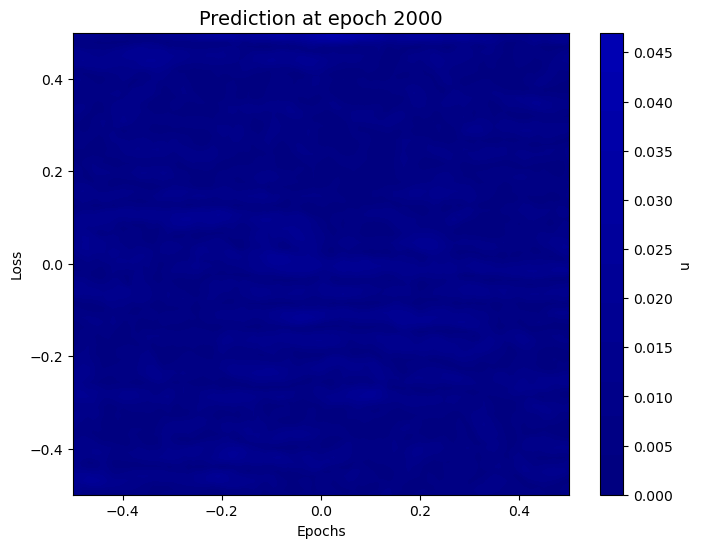

Updating best performing model. Current loss: 4.917942047119141.
Starting 1-th exploitation cycle.
Loss at epoch 1 is: 4.917745590209961. Current learing rate: 5e-05 
Loss at epoch 100 is: 4.898406505584717. Current learing rate: 5e-05 
Loss at epoch 200 is: 4.878952980041504. Current learing rate: 5e-05 
Loss at epoch 300 is: 4.859314441680908. Current learing rate: 5e-05 
Loss at epoch 400 is: 4.839238166809082. Current learing rate: 5e-05 
Loss at epoch 500 is: 4.818478107452393. Current learing rate: 5e-05 
Loss at epoch 600 is: 4.796784400939941. Current learing rate: 5e-05 
Loss at epoch 700 is: 4.773896217346191. Current learing rate: 5e-05 
Loss at epoch 800 is: 4.749538898468018. Current learing rate: 5e-05 
Loss at epoch 900 is: 4.723419666290283. Current learing rate: 5e-05 
Loss at epoch 1000 is: 4.695220947265625. Current learing rate: 5e-05 
Loss at epoch 1100 is: 4.66459321975708. Current learing rate: 5e-05 
Loss at epoch 1200 is: 4.631138801574707. Current learing rate

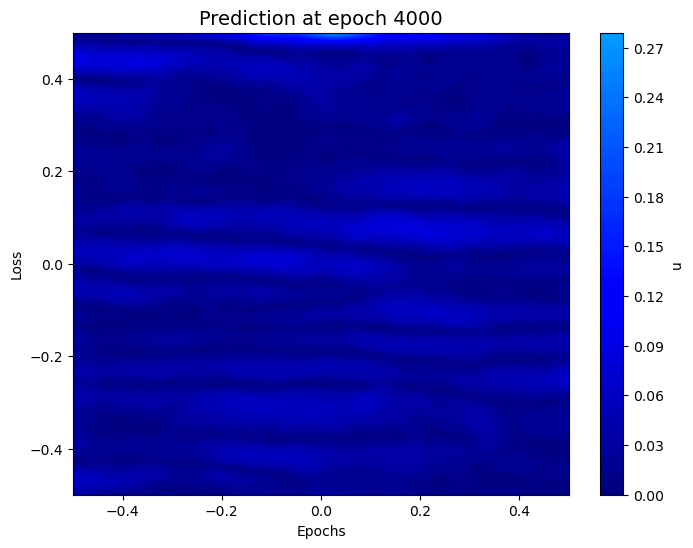

Updating best performing model. Current loss: 4.166825294494629.
Starting 2-th exploitation cycle.
Loss at epoch 1 is: 4.1658430099487305. Current learing rate: 5e-05 
Loss at epoch 100 is: 4.059530258178711. Current learing rate: 5e-05 
Loss at epoch 200 is: 3.9311845302581787. Current learing rate: 5e-05 
Loss at epoch 300 is: 3.777331590652466. Current learing rate: 5e-05 
Loss at epoch 400 is: 3.593548536300659. Current learing rate: 5e-05 
Loss at epoch 500 is: 3.376782178878784. Current learing rate: 5e-05 
Loss at epoch 600 is: 3.1279759407043457. Current learing rate: 5e-05 
Loss at epoch 700 is: 2.8544681072235107. Current learing rate: 5e-05 
Loss at epoch 800 is: 2.5708911418914795. Current learing rate: 5e-05 
Loss at epoch 900 is: 2.2964038848876953. Current learing rate: 5e-05 
Loss at epoch 1000 is: 2.0474653244018555. Current learing rate: 5e-05 
Loss at epoch 1100 is: 1.832388162612915. Current learing rate: 5e-05 
Loss at epoch 1200 is: 1.6506942510604858. Current lea

KeyboardInterrupt: 

In [107]:
train_ctx = train.TrainingContext(
    model=model,
    optimizer=optimizer,
    domain=domain,
    loss_fn=loss_fn,
    monitor_lr=True,
    resample=False
)

total_loss_values = []
minimal_loss_value = sys.maxsize

print('Starting training...')
print('Starting exploration phase...')
# Total 50 * 2000 = 100_000 epochs

# as no resampling is done, one must manually generate points
domain.generate_points()

for i in range(40):
    # explore solutions

    print(f'Starting {i}-th exploitation cycle.')

    train_ctx.epochs = 2000
    include_ri = False
    total_loss_values_exp_trc, component_wise_loss_values_exp_trc = train.simple_train(train_ctx)

    total_loss_values += total_loss_values_exp_trc

    plot_ctx.titles = [f'Prediction at epoch {(i + 1) * 2000}']
    plot_ctx.function_names = ['u']
    utils.plot_function_on_2d_cube([model_velocity_at_time], plot_ctx)
    
    if total_loss_values[-1] < minimal_loss_value:
        print(f'Updating best performing model. Current loss: {total_loss_values[-1]}.')

        minimal_loss_value = total_loss_values[-1]
        torch.save(model.state_dict(), TRAIN_TEMP_SAVE_PATH)

    # print('\'Exploring\'')
    # train_ctx.epochs = 500
    # include_ri = True
    # domain.metric_computed = False
    # total_loss_values_exp, component_loss_values_exp = train.simple_train(train_ctx)

    # utils.plot_points({'\"Good\" points': domain.interior[~domain.bad_pts_mask],
    #                        '\"Bad\" points': domain.interior[domain.bad_pts_mask]},
    #                        title=f'Point distribution at epoch {(i) * 2000}')

    # # train current solution
    # print('Done')

print('Finishing exploration phase...')
print('Selecting best performing model and starting fine-tuning phase...')

include_ri = False
model.load_state_dict(torch.load(TRAIN_TEMP_SAVE_PATH))
train_ctx.optimizer = torch.optim.Adam(model.parameters(), lr=5e-6)
train_ctx.epochs = 50_000
total_loss_values_ftn, component_wise_loss_values_ftn = train.train_switch_to_lbfgs(train_ctx, lbfgs_lr=0.1, epochs_with_lbfgs=1)

total_loss_values += total_loss_values_ftn

print('Finishing fine-tuning phase...')
print(f'Finishing training. Last loss: {total_loss_values[-1]}')

In [ ]:

# vykresleni ztraty
date = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M')

plot_ctx.save_path = f'cavity_flow_loss_{date}.png'
utils.plot_loss_values({'Total loss': total_loss_values}, plot_ctx)

# plot_ctx.x_label = 'x'
# plot_ctx.y_label = 'y'

def model_pde_residuum(x: torch.Tensor):
    x.requires_grad_(True)
    output = model(x)
    return pde_residuum(output, x)


def model_div_residuum(x: torch.Tensor):
    x.requires_grad_(True)
    output = model(x)
    return continuity_residuum(output, x)


# # vykresleni vysledku
# for t in [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]:
#     plot_ctx.title = f'Model at time t={t} with Re={RE}'
#     plot_ctx.save_path = f'images/cavity_flow_time_{t}.png'
#     utils.plot_vector_field_2d(lambda x: model_velocity_at_time(x, t), plot_ctx, N=25)

# vypis L2 normy residua
pde_res_l2 = calc.L2_norm(lambda x: 0, model_pde_residuum, 3, U_BOUNDS, L_BOUNDS, device, 20)
div_res_l2 = calc.L2_norm(lambda x: 0, model_div_residuum, 3, U_BOUNDS, L_BOUNDS, device, 20)

print('Writing log...')
with open(f'train_{date}_log.txt', 'a') as f:
    f.write(f'PDE residuum of model: {pde_res_l2}\n')
    f.write(f'Continuity condition residuum of model: {div_res_l2}\n')
    f.write(f'Last loss value: {total_loss_values[-1]}\n')
    f.write(f'Re: {RE}\n')
    f.write(f'A: {A}\n')


print('Saving finished model...')
torch.save(model.state_dict(), f'model_ns_re_{RE}_{date}.pt')
print('Model saved')
